# Model feature analysis of 3D objects

As a starting point, we extract features of the stimuli we used in the neurosketch study: four cars, four furniture items.
We use VGG16 as our feature extractor.  This will allow us to directly relate these object stimuli to our sketch data using the same feature embedding. Later, we will use these embeddings to connect to the neural data. 


In [1]:
# here are some set up code to ignore 
import numpy as np
import utils
import pickle
import scipy
from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag



%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Constants 

# I pulled activations of 8 layers. Here is the index ref to the layers
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 

LAYERS_NM = ['pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']
# constants for the images
NUM_VIEWS = 40
CARS = ['limo', 'suv', 'smart', 'sedan']
FURNITURES = ['bed', 'chair', 'table', 'bench']
OBJECTS = CARS + FURNITURES
# sample image url: https://s3.amazonaws.com/morphrecog-images-1/limoToSUV_10_10_99.png.png
CARS_label = ['limoToSUV_10','limoToSUV_99','smartToSedan_10','smartToSedan_99'];
FURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']
OBJECTS_label = CARS_label + FURNITURES_label 

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

# constants for train/test for the linear discriminability
TRAIN_SZ = 0.50
TEST_SZ = 1 - TRAIN_SZ


In [3]:
# pulling/cleaning up the data

# downloading the activations. I had to split the sample (each act has 160 images) because they're about 3GB each. 
act1 = pickle.load(open('activations.p', 'rb'))
act2 = pickle.load(open('activations2.p', 'rb'))

IOError: [Errno 2] No such file or directory: 'activations.p'

In [ ]:
# pulling out all the fc6, fc7 layers for all images to have a smaller set to work with. 
fc6 = np.vstack((np.asarray(act1[LAYERS['fc6']]), np.asarray(act2[LAYERS['fc6']])))
fc7 = np.vstack((np.asarray(act1[LAYERS['fc7']]), np.asarray(act2[LAYERS['fc7']])))


# pulling out remaining pooling layers
pool = [] 

for i in xrange(0,5):
    pool1_i, pool2_i = np.asarray(act1[i]), np.asarray(act2[i])

    pool_i = np.vstack((pool1_i.reshape(pool1_i.shape[0], pool1_i.shape[1] * pool1_i.shape[2] * pool1_i.shape[3]), 
                     pool2_i.reshape(pool2_i.shape[0], pool2_i.shape[1] * pool2_i.shape[2] * pool2_i.shape[3])))
    pool.append(pool_i)



In [ ]:
all_layers = pool
all_layers.append(fc6)
all_layers.append(fc7)

## 1. Representational Similarity Analysis

We want to relate the model's feature representation of the actual 3D objects participants viewed to its representation of the sketches people produced during training. As a first step, we analyze the category-level and object-level similarity for the 3D objects, at each layer of VGG.

To do this, we extract one feature vector for each of the 40 views of each object, take the mean vector within object, and compute the correlations between these mean vectors. We use raw activations for this analysis. This yields an 8x8 correlation matrix for each VGG layer.



In [ ]:
# getMeanVector gets the mean vector across number of views for num_objects 
def getMeanVector(full_batch, num_views, num_objects):
    meanVector = np.empty((num_objects, full_batch.shape[1]), float)
    for i in xrange(0, num_objects):
        # pull out the views of the particular object 
        all_views = full_batch[i * num_views: (i + 1) * num_views, :]
        meanVector[i,:] = np.mean(all_views, axis = 0)

    
    return meanVector

In [ ]:
RDM_fc7 = np.corrcoef(getMeanVector(fc7, NUM_VIEWS, len(OBJECTS))) 
RDM_fc6 = np.corrcoef(getMeanVector(fc6, NUM_VIEWS, len(OBJECTS))) 

RDM_pool = []
for pool_layer in xrange(0,5):
    RDM_pool_i = np.corrcoef(getMeanVector(pool[pool_layer], NUM_VIEWS, len(OBJECTS)))
    RDM_pool.append(RDM_pool_i)


In [1]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


for pool_layer in xrange(0,5):
    pltname = "Pool " + str(pool_layer + 1)
    plt.subplot(1, 5, pool_layer + 1)
    plt.title(pltname)
    plt.imshow(RDM_pool[pool_layer])
    plt.xticks(xrange(0,len(OBJECTS)), OBJECTS, rotation='vertical')
    
    if pool_layer == 0:
        plt.yticks(xrange(0,len(OBJECTS)), OBJECTS)
    else:
        plt.yticks([])

fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(RDM_fc6)
plt.title("fc6")
plt.xticks(xrange(0,len(OBJECTS)), OBJECTS, rotation='vertical')
plt.yticks(xrange(0,len(OBJECTS)), OBJECTS)

plt.subplot(122)
plt.imshow(RDM_fc7)
plt.title("fc7")
plt.xticks(xrange(0,len(OBJECTS)), OBJECTS, rotation='vertical')
plt.yticks(xrange(0,len(OBJECTS)), OBJECTS)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal', ax=cax)
plt.show()

NameError: name 'plt' is not defined

Note that the category-level and object-level discriminability increases by model layer. Visually, this is captured by comparing the off-diagonal entries of the 4x4 on-diagonal blocks (“within”) to the 4x4 off-diagonal block (“between”). To quantify the strength of category-level clustering by model layer, we compute the difference between the mean “within” and the mean of the “between” entries, and visualize this below)




In [ ]:
def getRDM_mean(rdm):

    # get upper triangle without diagnoal 
    rdm_all = np.triu(rdm, 1) 
    

    
    # upper right block is the between car/furniture category  
    rdm_between = rdm_all[:-4, 4:]
    mean_between = rdm_between.flatten().sum()/16
    
    
    # everything else is within categories 
    rdm_within = rdm_all
    rdm_within[:-4, 4:] = 0
    mean_within = rdm_within.flatten().sum()/12

    return (mean_within, mean_between, abs(mean_within - mean_between))
        

In [ ]:

RDM_meanWithin = [] #np.ones((1,len(LAYERS)), float)
RDM_meanBetween = [] #np.ones((1,len(LAYERS)), float)
RDM_meanDiff = [] # np.ones((1,len(LAYERS)), float)
for pool_layer in xrange(0,5):
    mean_vals_i = getRDM_mean(RDM_pool[pool_layer])
    RDM_meanWithin.append(mean_vals_i[0])
    RDM_meanBetween.append(mean_vals_i[1])
    RDM_meanDiff.append(mean_vals_i[2])


for layer in (RDM_fc6, RDM_fc7):
    mean_vals_i = getRDM_mean(layer)
    RDM_meanWithin.append(mean_vals_i[0])
    RDM_meanBetween.append(mean_vals_i[1])
    RDM_meanDiff.append(mean_vals_i[2])



In [ ]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.title("RDM Mean within and between categories")
plt.ylabel("Mean")
plt.xlabel("Layer")

plt.bar(np.arange(len(LAYERS_NM))-0.2, RDM_meanWithin, width = 0.2, label= "mean within categories")
plt.bar(np.arange(len(LAYERS_NM)),RDM_meanBetween,width = 0.2, label = "mean between categories")
plt.plot(RDM_meanDiff, label = "difference between the means", color='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(xrange(0,len(LAYERS)), LAYERS_NM);
axes = plt.gca()
axes.set_ylim([0,1]);


We also expect to see that object-level discriminability increases by model layer. To do this, we take the full 320x320 image matrix, and perform an analogous computation where we compare the within-object similarities across views to the between-object similarities within class. In other words, the mean similarity across views of a chair compared to the mean similarity between chair and the other three furniture items. We plot this below:



In [ ]:
# code from stack exchange (https://goo.gl/MRHFQw) 
# Extracts blocks of size M from the kth diagonal
# of square matrix A, whose size must be a multiple of n.
def extract_block_diag(a, n, k=0):

    a = np.asarray(a)
    if a.ndim != 2:
        raise ValueError("Only 2-D arrays handled")
    if not (n > 0):
        raise ValueError("Must have n >= 0")

    if k > 0:
        a = a[:,n*k:] 
    else:
        a = a[-n*k:]

    n_blocks = min(a.shape[0]//n, a.shape[1]//n)

    new_shape = (n_blocks, n, n)
    new_strides = (n*a.strides[0] + n*a.strides[1],
                   a.strides[0], a.strides[1])

    return np.lib.stride_tricks.as_strided(a, new_shape, new_strides)



In [ ]:
# making the RDM for all 
RDM_fc7_a = np.corrcoef(fc7) 
RDM_fc6_a = np.corrcoef(fc6)

RDM_pool_a = []
for pool_layer in xrange(0,5):
    RDM_pool_i = np.corrcoef(pool[pool_layer])
    
    RDM_pool_a.append(RDM_pool_i)



In [ ]:


fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


for pool_layer in xrange(0,5):
    pltname = "Pool " + str(pool_layer + 1)
    plt.subplot(1, 5, pool_layer + 1)
    plt.title(pltname)
    plt.imshow(RDM_pool_a[pool_layer])
    
    plt.xticks(np.arange(NUM_VIEWS/2, len(OBJECTS) * NUM_VIEWS, NUM_VIEWS), OBJECTS, rotation='vertical')
    if pool_layer == 0: 
        plt.yticks(np.arange(NUM_VIEWS/2, len(OBJECTS) * NUM_VIEWS, NUM_VIEWS), OBJECTS)
    else: 
        plt.yticks([])


fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(RDM_fc6_a)
plt.title("fc6")
plt.xticks(np.arange(NUM_VIEWS/2, len(OBJECTS) * NUM_VIEWS, NUM_VIEWS), OBJECTS, rotation='vertical')
plt.yticks(np.arange(NUM_VIEWS/2, len(OBJECTS) * NUM_VIEWS, NUM_VIEWS), OBJECTS)


plt.subplot(122)
plt.imshow(RDM_fc7_a)
plt.title("fc7")
plt.xticks(np.arange(NUM_VIEWS/2, len(OBJECTS) * NUM_VIEWS, NUM_VIEWS), OBJECTS, rotation='vertical')
plt.yticks(np.arange(NUM_VIEWS/2, len(OBJECTS) * NUM_VIEWS, NUM_VIEWS), OBJECTS)


cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal', ax=cax)
plt.show()

In [ ]:
# we'll only look at the furnitures for now 
RDM_fc7_f = RDM_fc7_a[-160:, -160:]
RDM_fc6_f = RDM_fc6_a[-160:, -160:]

RDM_pool_f = []
for pool_layer in xrange(0,5):
    
    RDM_pool_f.append(RDM_pool_a[pool_layer][-160:, -160:])


In [ ]:
# calculating the within object and cross object mean within the same class

def getMeanWithinClass(rdm, num_views, num_objects):
    if num_objects != 4: # && num_objects != 8: 
        print "need to alter this fnc for getting mean across class." 
        
    # take out the upper triangle first + get the diagnoals 
    within_object_blocks = extract_block_diag(np.triu(rdm, 1) , num_views)
    within_object_mean = within_object_blocks.flatten().sum()/np.count_nonzero(within_object_blocks)


        
    # clear out the diagonal blocks. warning: this is really hacky. 
    diag_blocks = np.ones((num_views,num_views)) * -1 
    rdm_cross = np.triu(rdm, 1) * (block_diag(diag_blocks, diag_blocks, diag_blocks, diag_blocks) + 1 )
    
    cross_object_mean = rdm_cross.flatten().sum()/np.count_nonzero(rdm_cross)

    return (within_object_mean, cross_object_mean, abs(within_object_mean - cross_object_mean))




In [ ]:

RDM_meanWithin_f = [] #np.ones((1,len(LAYERS)), float)
RDM_meanCross_f = [] #np.ones((1,len(LAYERS)), float)
RDM_meanDiff_f = [] # np.ones((1,len(LAYERS)), float)
for pool_layer in xrange(0,5):
    mean_vals_i = getMeanWithinClass(RDM_pool_f[pool_layer], NUM_VIEWS, len(FURNITURES))
    RDM_meanWithin_f.append(mean_vals_i[0])
    RDM_meanCross_f.append(mean_vals_i[1])
    RDM_meanDiff_f.append(mean_vals_i[2])


for layer in (RDM_fc6_f, RDM_fc7_f):
    mean_vals_i = getMeanWithinClass(layer, NUM_VIEWS, len(FURNITURES))
    RDM_meanWithin_f.append(mean_vals_i[0])
    RDM_meanCross_f.append(mean_vals_i[1])
    RDM_meanDiff_f.append(mean_vals_i[2])



In [ ]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("RDM Mean between-objects and within-objects for furnitures ")
plt.ylabel("Mean")
plt.xlabel("Layer")
plt.bar(np.arange(len(LAYERS_NM))-0.2, RDM_meanWithin_f, width = 0.2, label= "mean within 40 views of objects")
plt.bar(np.arange(len(LAYERS_NM)),RDM_meanCross_f,width = 0.2, label = "mean between objects (within same categories)")
plt.plot(RDM_meanDiff_f, label = "difference between the means", color='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(xrange(0,len(LAYERS)), LAYERS_NM);
axes = plt.gca()
axes.set_ylim([0,1.0]);

## Classifier-based Discriminability

To directly measure object-level discriminability across model layer, we also train a 4-way (& 8-way) logistic regression classifier. We used a 50/50 train/test split within object class. We did not L2-normalize feature vectors prior to training classifier.

However, our imageset was sufficiently clean that even training the model on the first pool layer would lead to a ceiling performance (100% accuracy).  




In [10]:

# full_batch: the full batch of images. I am assuming that the full_batch is arranged as 40 views of obj1, 40 objects of obj2... so forth.  
# train_sz: needs to be a probability, s.t. test_sz = 1 - train-sz. 
def getData(full_batch, num_views, num_objects, test_sz):
    
    num_train = int(num_views * (1 - test_sz))
    num_test = num_views - num_train
    
    X_train = np.ones((num_train * num_objects, full_batch.shape[1]), float)
    X_test = np.ones((num_test * num_objects, full_batch.shape[1]), float)
    
    for i in xrange(0, num_objects):
        X = full_batch[i * num_views: (i + 1) * num_views, :]
        
        # randomly shuffle the train/test for the x 
        X_train_i, X_test_i = train_test_split(X, test_size=test_sz)
        X_train[i * num_train: (i + 1) * num_train, :] = X_train_i
        X_test[i * num_test: (i + 1) * num_test, :] = X_test_i
        
        

    y_train = np.repeat(xrange(0, num_objects), num_train)
    y_test = np.repeat(xrange(0, num_objects), num_test)

    return (X_train, y_train, X_test, y_test)

In [18]:
# checking pixel level classifier(move this up later so we can include this in the line graph) 

pixel = np.empty((NUM_VIEWS * len(OBJECTS), VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
pixel_i = 0 # used for the batch index 
for obj in CARS_label + FURNITURES_label:
    for view in xrange(0,NUM_VIEWS):        
        imgname = obj + '_' + str(view) + '.png.png'
        imgloc = 'object_data/' + imgname
        img = utils.load_image(imgloc)

        img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
        
        pixel[pixel_i, :] = img
        pixel_i += 1 




In [20]:
layer_score = []

# pixel layer first
logreg = linear_model.LogisticRegression()
X_train, y_train, X_test, y_test = getData(pixel, NUM_VIEWS, len(OBJECTS), TEST_SZ)
score = logreg.fit(X_train, y_train).score(X_test, y_test)
print ("Logistic Regression score on pixel layer is %f", score)
layer_score.append(score) 


for i in xrange(0,len(LAYERS_NM)):
    logreg = linear_model.LogisticRegression()
    X_train, y_train, X_test, y_test = getData(all_layers[i], NUM_VIEWS, len(OBJECTS), TEST_SZ)
    score = logreg.fit(X_train, y_train).score(X_test, y_test)
    print ("Logistic Regression score on layer %s is %f", LAYERS_NM[i], score)
    layer_score.append(score) 


('Logistic Regression score on pixel layer is %f', 0.98124999999999996)
('Logistic Regression score on layer %s is %f', 'pool1', 0.99375000000000002)
('Logistic Regression score on layer %s is %f', 'pool2', 1.0)
('Logistic Regression score on layer %s is %f', 'pool3', 0.98750000000000004)
('Logistic Regression score on layer %s is %f', 'pool4', 0.98750000000000004)
('Logistic Regression score on layer %s is %f', 'pool5', 1.0)
('Logistic Regression score on layer %s is %f', 'fc6', 0.99375000000000002)
('Logistic Regression score on layer %s is %f', 'fc7', 0.98750000000000004)


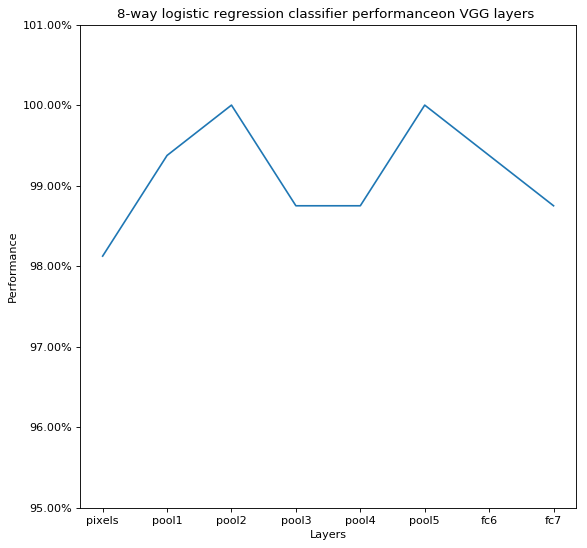

In [23]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("8-way logistic regression classifier performanceon VGG layers ")
plt.plot(np.arange(len(LAYERS_NM) + 1 ), layer_score)
plt.xlabel('Layers')
plt.ylabel('Performance')

x_label = LAYERS_NM
x_label.insert(0, "pixels")

plt.xticks(xrange(0,len(LAYERS) + 1), x_label);
axes = plt.gca()
axes.set_ylim([0.95,1.01]);
vals = axes.get_yticks()
axes.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals]);